<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/Exposure_Time_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from astropy.modeling import fitting, models

from scipy.integrate import quadrature,trapz

sb.set_style('dark')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

In [1]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (403/403), done.
remote: Total 782 (delta 228), reused 5 (delta 2), pack-reused 375
Receiving objects: 100% (782/782), 90.75 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (416/416), done.


In [3]:
cd INSIST/data

/content/INSIST/data


# **Exposure Time Calulator**

In [4]:
df = pd.read_csv('detector_parameters.csv')
df

,filter,wavelength,bandwidth,effective_area,sky_brightness,plate_scale,aperture,dark_current,read_noise
0,UVIT NUV,2418,767,40.00000,24.50,1.50,4.50,0.0000,0.0
1,UVIT FUV,1541,372,10.00000,25.00,1.50,4.50,0.0000,0.0
2,GALEX NUV,2304,768,34.00000,26.50,1.50,15.90,0.0000,0.0
3,GALEX FUV,1549,265,20.00000,29.90,1.50,12.60,0.0000,0.0
4,LSST LU,3751,516,110835.40000,23.08,0.20,1.80,2.0000,5.0
5,LSST LG,4741,1461,199503.70000,21.90,0.20,1.80,2.0000,5.0
6,EUCLID V,6872,3698,4841.75600,21.40,0.10,0.45,0.0006,3.6
7,EUCLID VEX,6872,3698,4841.75600,21.40,0.10,1.29,0.0006,3.6
8,INSIST UV,2250,1500,1042.30504,27.50,0.15,0.60,0.1000,3.0
9,INSIST U,3641,700,2676.53120,23.08,0.15,0.60,0.1000,3.0


In [42]:
def coeff_calc(x0,xn,x=None,y=None,mode = None):
  if mode == 'Gaussian':
    model = models.Gaussian1D(mean = (x0+xn)*0.5, stddev = xn-x0)
    int_y,err = quadrature(model,x0,xn)
    return int_y/(xn-x0)
  else :
    return trapz(y,x)/(xn-x0)

In [43]:
coeff_calc(150,300,x,y)

0.9598504379179228

In [5]:
def exposure_time(det_params,M,SNR):
  wavelength     = det_params['wavelength']
  bandwidth      = det_params['bandwidth']
  effective_area = det_params['effective_area']
  M_sky          = det_params['sky_brightness']
  plate_scale    = det_params['plate_scale']
  aperture       = det_params['aperture']
  dark_current   = det_params['dark_current']
  read_noise     = det_params['read_noise']

  F_0_p   = 1.51e3*(bandwidth/wavelength)*3631*effective_area
  F_m_p   = F_0_p*pow(10,-0.4*M)
  M_sky_p = M_sky - 2.5*np.log10(plate_scale**2)
  F_sky_p = F_0_p*pow(10,-0.4*M_sky_p)

  n_pix   = np.pi*((0.5*aperture)/plate_scale)**2

  A =  (F_m_p/SNR)**2
  B = -(F_m_p + F_sky_p*n_pix + dark_current*n_pix)
  C = -n_pix*(read_noise)**2

  t1 = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)
  t2 = (-B - np.sqrt(B**2 - 4*A*C))/(2*A)
  t = np.where(t1>0,t1/60,t2/60)
  
  return t

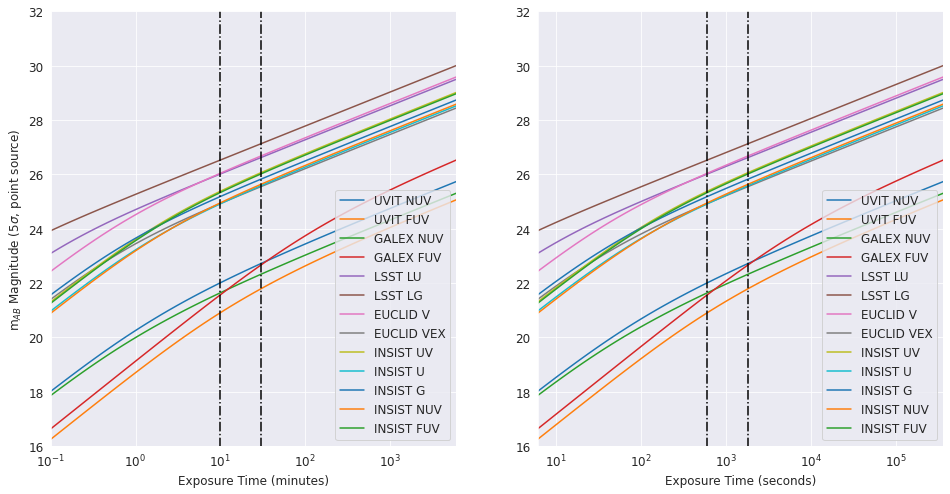

In [6]:
fig,ax = plt.subplots(1,2,figsize = (16,8))
for i, row in df.iterrows():
  mag = np.linspace(16,32,100)
  time = exposure_time(row,mag,5.0)
  ax[0].plot(time,mag)
  ax[1].plot(time*60,mag)

ax[0].plot([10.0, 10.0], [0.0, 50.0], '-.k')
ax[0].plot([30.0, 30.0], [0.0, 50.0], '-.k')
ax[0].grid(True)
ax[0].set_xscale('log')
ax[0].set_ylim(16.0, 32.0)
ax[0].set_ylabel(r'm$_{AB}$ Magnitude (5$\sigma$, point source)', fontsize=12)
ax[0].set_xlabel('Exposure Time (minutes)', fontsize=12)
ax[0].set_xlim(0.1, 6000.0)
ax[0].legend(df['filter'].values)

ax[1].plot([600.0, 600.0], [0.0, 50.0], '-.k')
ax[1].plot([1800.0, 1800.0], [0.0, 50.0], '-.k')
ax[1].grid(True)
ax[1].set_xscale('log')
ax[1].set_ylim(16.0, 32.0)
ax[1].set_xlabel('Exposure Time (seconds)', fontsize=12)
ax[1].set_xlim(6, 360000.0)
ax[1].legend(df['filter'].values)